<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

План работы:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
!pip install --upgrade pip
!pip install --upgrade Pillow
!pip install --upgrade scikit-learn==1.5.0
!pip install --upgrade numpy==1.24.4
!pip install prophet
!pip install catboost

In [2]:
import pandas as pd

import numpy

import lightgbm
from lightgbm import LGBMRegressor

import statsmodels.tools
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
from statsmodels.graphics import tsaplots
from statsmodels.tools.eval_measures import rmse

from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

import sklearn
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyRegressor

import os

import matplotlib.pyplot as plt

import seaborn as sns

import lightgbm
from lightgbm import LGBMRegressor

import catboost
from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
pd.set_option('display.max_columns', None)

<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
Отлично, все нужные библиотеки импортированы в начале ноутбука.Это хорошая практика.</div>

In [3]:
RANDOM_STATE = 42

Библиотеки подключены, нужные инструменты импортированы.

Переходим к загрузке данных.

In [4]:
pth1 = r'c:\users\natasha\desktop\taxi.csv'

if os.path.exists(pth1):
    taxi = pd.read_csv(pth1, parse_dates = [0])
else:
    print('Что-то пошло не так!')

taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


Установим индекс таблицы равным столбцу datetime и отсортируем индексы.

In [5]:
taxi=taxi.set_index('datetime')

In [6]:
taxi = taxi.sort_index()

In [7]:
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Выполним ресемплирование данных по одному часу.

In [8]:
taxi = taxi.resample('1H').sum()

C:\Users\Natasha\AppData\Local\Temp\ipykernel_7896\1260743984.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  taxi = taxi.resample('1H').sum()


In [9]:
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Данные загружены, пропусков нет, типы данных соответствуют содержанию.
Столбец datetime стал индексами, отсортирован по возрастанию.

## Анализ

Построим график временного ряда.

На графике видим тренд на увеличение заказов.
Можно предположить, что в данных есть сезонность - 1 сутки.

Отобразим на графике скользящее среднее и стандартное отклонение за 24 часа

<Figure size 1500x800 with 0 Axes>

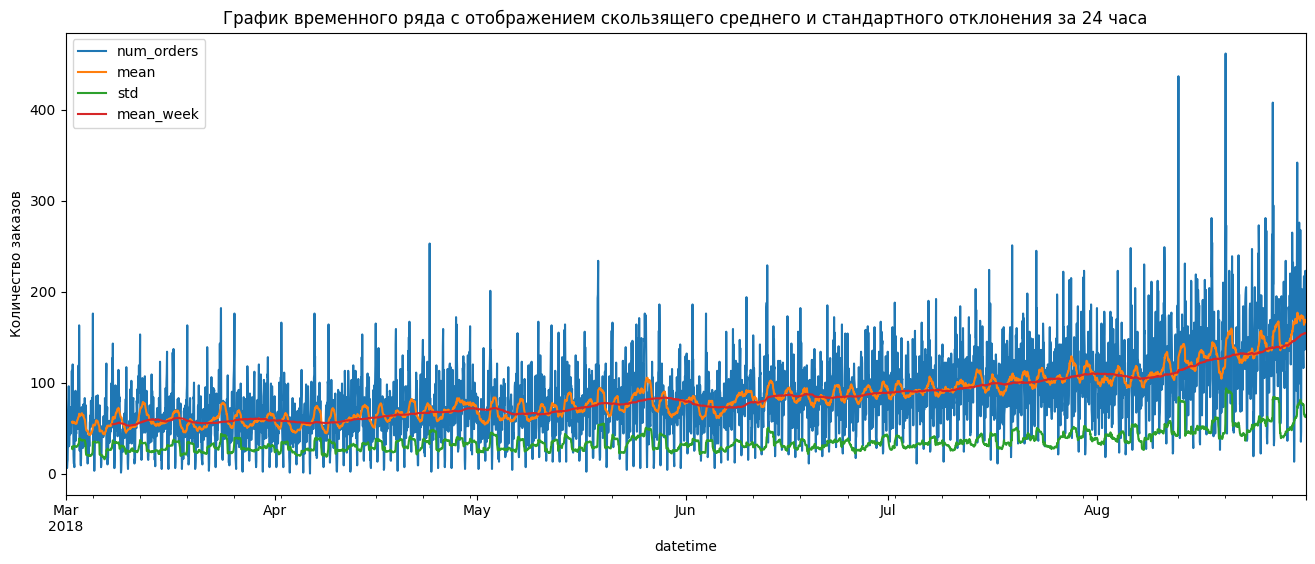

In [10]:
taxi_plot = taxi.copy()

plt.figure(figsize=(15, 8))
taxi_plot['mean'] = taxi_plot['num_orders'].rolling(24).mean()
taxi_plot['std'] = taxi_plot['num_orders'].rolling(24).std()
taxi_plot['mean_week'] = taxi_plot['num_orders'].rolling(168).mean()
taxi_plot.plot(figsize=(16, 6))
plt.ylabel('Количество заказов')
plt.title('График временного ряда с отображением скользящего среднего и стандартного отклонения за 24 часа')
plt.show()

Декомпозиция и автокорреляция данных также показывает наличие тренда и сезонности. Но тренд постоянно меняется.

<Figure size 1600x500 with 0 Axes>

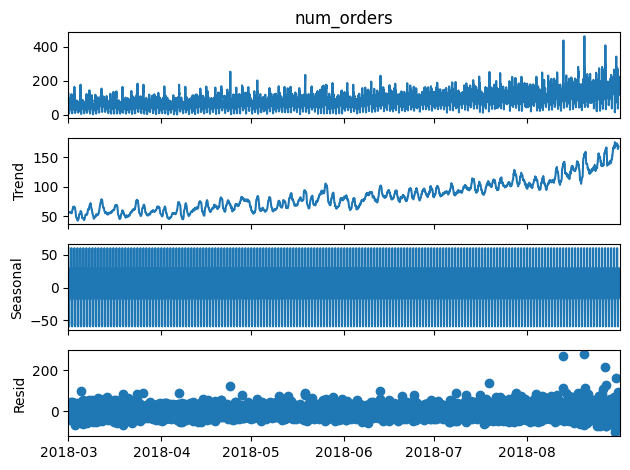

In [11]:
plt.figure(figsize=(16, 5))
sm.tsa.seasonal_decompose(taxi['num_orders']).plot()
plt.show()

In [12]:
#decompose = sm.tsa.seasonal_decompose(taxi['num_orders'])

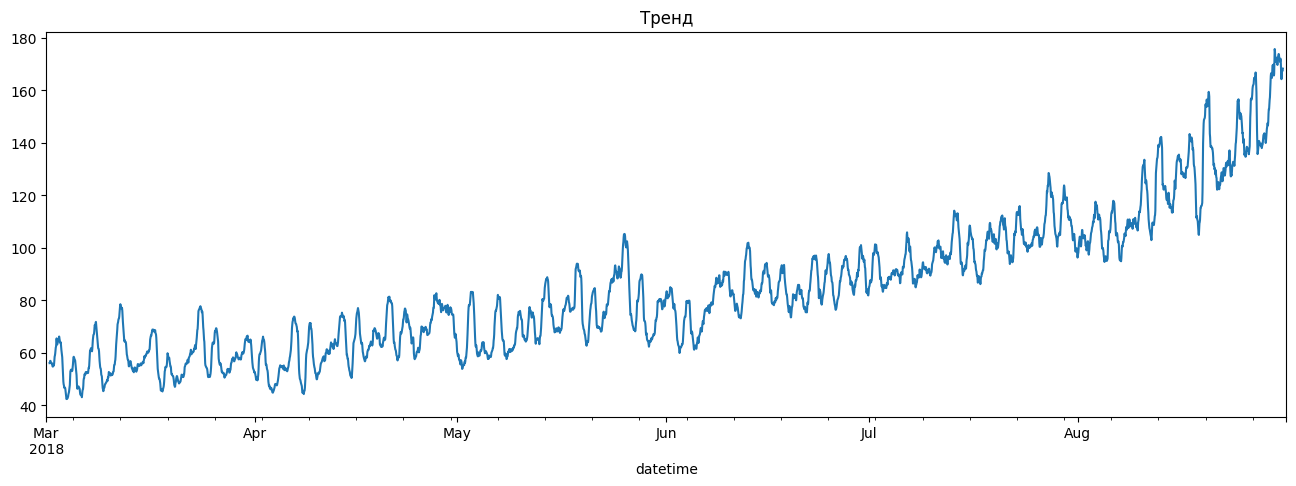

In [13]:
decomposed = smt.seasonal_decompose(taxi)

plt.figure(figsize=(16, 5))
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.show()

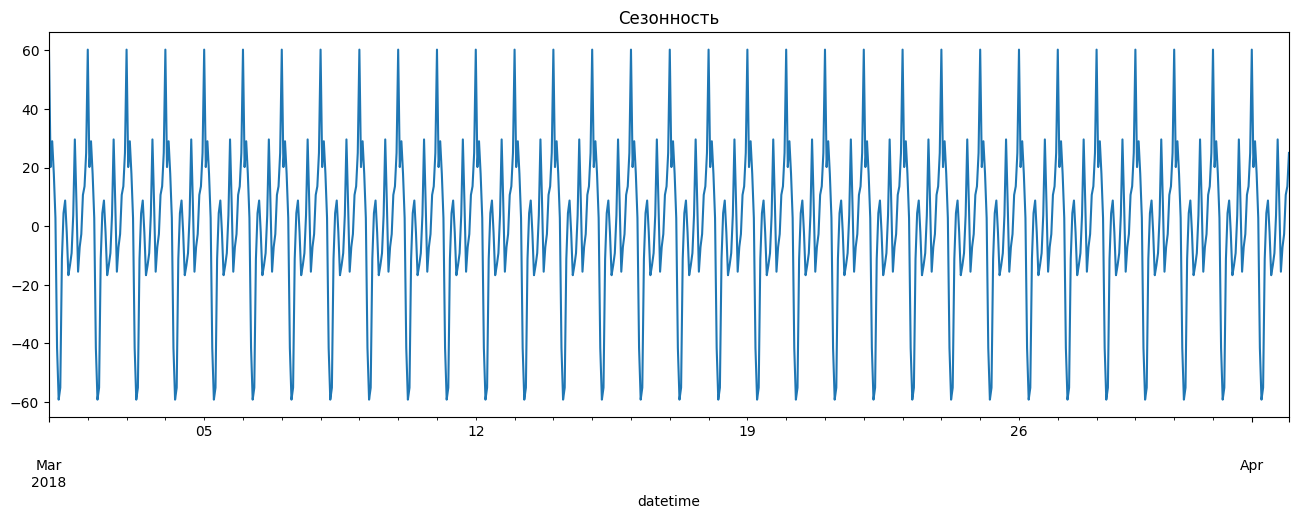

In [14]:
plt.figure(figsize=(16, 5))
decomposed.seasonal[:'2018-04-01'].plot(ax=plt.gca())
plt.title('Сезонность')
plt.show()

Тренд и сезонность вывела отдельными графиками.
    
По графикам автокорреляции четко видна суточная сезонность и не так ярко выражена, но присутствует недельная сезонность.

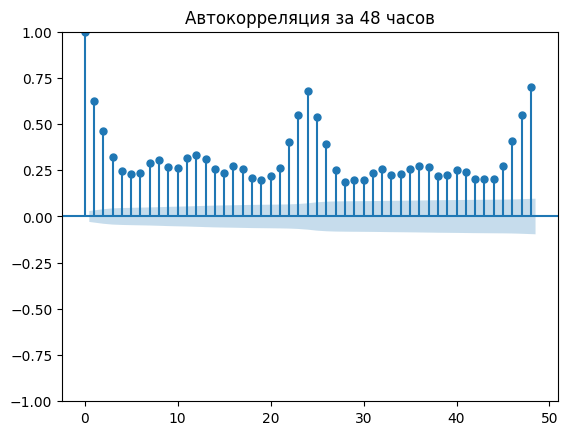

In [15]:
fig = tsaplots.plot_acf(taxi['num_orders'], lags=48)
plt.title('Автокорреляция за 48 часов')
plt.show();

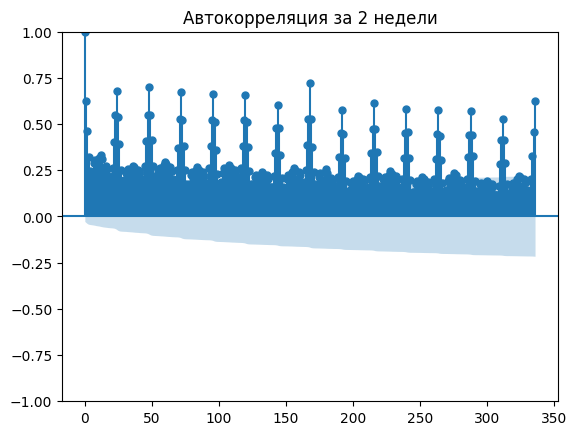

In [16]:
fig = tsaplots.plot_acf(taxi['num_orders'], lags=336)
plt.title('Автокорреляция за 2 недели')
plt.show();

Для проверки временного ряда на стационарность воспользуемся расширенным тестом Дики-Фуллера.
Нулевая гипотеза - ряд нестационарный.
Альтернативная гипотеза - ряд стационарный.

In [17]:
def test(series, alpha=0.01):
    p_value = ts.adfuller(series)[1]
    print(f"p-value = {p_value}")
    if p_value > alpha:
        print('Не отвергаем нулевую гипотезу')
    else:
        print('Отвергаем нулевую гипотезу')

In [18]:
test(taxi['num_orders'])

p-value = 0.028940051402613028
Не отвергаем нулевую гипотезу


In [19]:
taxi_diff = taxi['num_orders'] - taxi['num_orders'].shift(24 , fill_value=0)
test(taxi_diff)

p-value = 1.4072336371524902e-28
Отвергаем нулевую гипотезу


Тест показал, что ряд можно считать стационарным после вычисления разностей его значений с интервалом в 24 часа.

<div class="alert" style="background-color:#ead7f7;color:#8737bf">
Анализ данных показал:
    
    -  временной ряд нельзя считать стационарным, так как присутствует тренд.
    
    -  ряд имеет сезонность в 1 сутки и 1 неделю.
    
    -  ряд можно привести к стационарнности, вычислив разности между значениями ряда с интервалом в 24 часа.
</div>

## Обучение

**Модель Prophet**

Сначала приведем данные к необходимому для модели виду, разделим на тренировочную и тестовую выборки.

In [20]:
taxi_pr = taxi.reset_index()[['datetime', 'num_orders']].copy()

In [21]:
taxi_pr.columns = ['ds', 'y']

In [22]:
TEST_SIZE = int(0.1 * taxi_pr.shape[0])

train_taxi = taxi_pr.iloc[:-TEST_SIZE]
test_taxi = taxi_pr.iloc[-TEST_SIZE:]

Инициализируем, обучим модель, получим предсказания.

In [23]:
model_1 = Prophet()
model_1.fit(train_taxi)

19:09:38 - cmdstanpy - INFO - Chain [1] start processing
19:09:39 - cmdstanpy - INFO - Chain [1] done processing


In [24]:
future = model_1.make_future_dataframe(periods = TEST_SIZE, freq='H')
forecast = model_1.predict(future)

C:\Users\Natasha\.conda\envs\practicum\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


Посмотрим на полученные предсказания.

In [25]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
4411,2018-08-31 19:00:00,125.521749,93.098609,157.858709,125.048468,125.996521,0.005883,0.005883,0.005883,-11.902643,-11.902643,-11.902643,11.908526,11.908526,11.908526,0.0,0.0,0.0,125.527632
4412,2018-08-31 20:00:00,125.545320,100.089610,165.660157,125.070877,126.022797,7.094548,7.094548,7.094548,-4.788584,-4.788584,-4.788584,11.883132,11.883132,11.883132,0.0,0.0,0.0,132.639868
4413,2018-08-31 21:00:00,125.568892,117.523070,177.393058,125.093286,126.048029,21.964322,21.964322,21.964322,10.214496,10.214496,10.214496,11.749826,11.749826,11.749826,0.0,0.0,0.0,147.533213
4414,2018-08-31 22:00:00,125.592463,131.305983,192.642224,125.115747,126.072727,34.925527,34.925527,34.925527,23.416812,23.416812,23.416812,11.508715,11.508715,11.508715,0.0,0.0,0.0,160.517990
4415,2018-08-31 23:00:00,125.616034,135.641358,194.458058,125.138243,126.097424,41.170922,41.170922,41.170922,30.009711,30.009711,30.009711,11.161211,11.161211,11.161211,0.0,0.0,0.0,166.786956


C:\Users\Natasha\.conda\envs\practicum\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\Natasha\.conda\envs\practicum\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


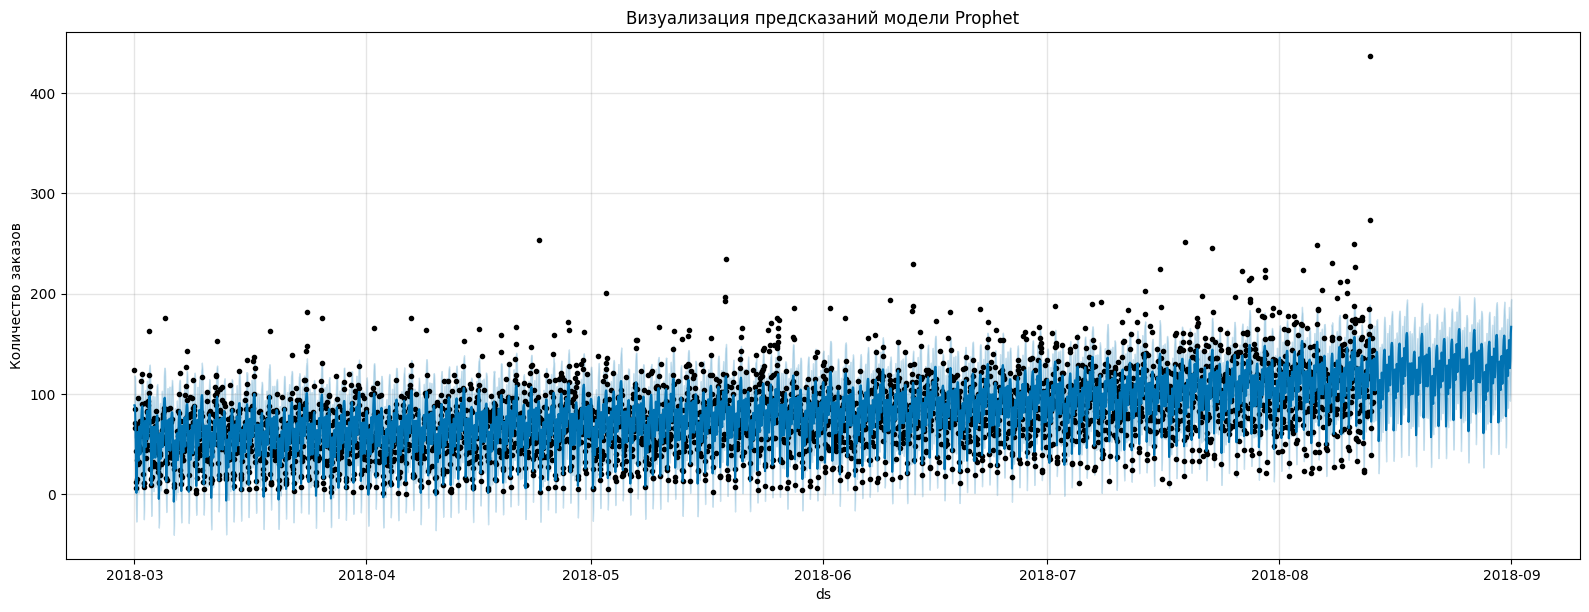

In [26]:
model_1.plot(forecast, figsize=(16, 6))
plt.title('Визуализация предсказаний модели Prophet')
plt.ylabel('Количество заказов')
plt.show()

Поскольку нас интересуют только предсказанные значения (yhat), составим датафрейм, состоящий из этого столбца и даты.

In [27]:
pred_pr = pd.DataFrame({"date":forecast['ds'],
                        "pred":forecast['yhat']})

pred_pr = pred_pr.set_index(['date'])
pred_pr[-TEST_SIZE:].tail()

,pred
date,
2018-08-31 19:00:00,125.527632
2018-08-31 20:00:00,132.639868
2018-08-31 21:00:00,147.533213
2018-08-31 22:00:00,160.517990
2018-08-31 23:00:00,166.786956


In [28]:
print("RMSE обучающей выборки модели Prophet:", rmse(train_taxi['y'], pred_pr[:-TEST_SIZE]['pred']))

RMSE обучающей выборки модели Prophet: 24.585687038919588


**Модель CatBoost**

Создадим дополнительные признаки.

In [29]:
def make_features(taxi, max_lag, rolling_mean_size_1, rolling_mean_size_2):
    taxi['hour'] = taxi.index.day
    taxi['dayofweek'] = taxi.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        taxi['lag_{}'.format(lag)] = taxi['num_orders'].shift(lag)

    taxi['rolling_mean_1'] = taxi['num_orders'].shift().rolling(rolling_mean_size_1).mean()
    taxi['rolling_mean_2'] = taxi['num_orders'].shift().rolling(rolling_mean_size_2).mean()


make_features(taxi, 168, 24, 168)
taxi.shape

C:\Users\Natasha\AppData\Local\Temp\ipykernel_7896\2821526040.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  taxi['lag_{}'.format(lag)] = taxi['num_orders'].shift(lag)
C:\Users\Natasha\AppData\Local\Temp\ipykernel_7896\2821526040.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  taxi['lag_{}'.format(lag)] = taxi['num_orders'].shift(lag)
C:\Users\Natasha\AppData\Local\Temp\ipykernel_7896\2821526040.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, wh

(4416, 173)

Разобьем данные на тренировочную и тестовую выборку, удалим строки с пустыми значениями, образовавшимися при создании новых признаков.

In [30]:
train, test = train_test_split(taxi, shuffle=False, test_size=0.1)
train = train.dropna()

X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']

X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

Обучим модель, подобрав наилучшие параметры.

In [31]:
tscv = TimeSeriesSplit(n_splits=5)
param_model_2 = {
    'max_depth': (3, 5),
    'eta': (0.1, 0.3),
    'n_estimators': (30, 50, 100)
}


model_2 = GridSearchCV(
    CatBoostRegressor(random_state=RANDOM_STATE), 
    param_model_2, 
    scoring='neg_root_mean_squared_error',
    cv = tscv,
    n_jobs=-1
)

model_2.fit(X_train, y_train)

0:	learn: 36.7281821	total: 165ms	remaining: 16.3s
1:	learn: 34.8041703	total: 178ms	remaining: 8.71s
2:	learn: 33.1419083	total: 190ms	remaining: 6.15s
3:	learn: 31.6673889	total: 203ms	remaining: 4.88s
4:	learn: 30.3944122	total: 216ms	remaining: 4.11s
5:	learn: 29.2788077	total: 229ms	remaining: 3.58s
6:	learn: 28.3841212	total: 241ms	remaining: 3.2s
7:	learn: 27.5661022	total: 252ms	remaining: 2.9s
8:	learn: 26.7258751	total: 261ms	remaining: 2.64s
9:	learn: 26.0231393	total: 271ms	remaining: 2.44s
10:	learn: 25.3654242	total: 281ms	remaining: 2.27s
11:	learn: 24.8305812	total: 289ms	remaining: 2.12s
12:	learn: 24.3555495	total: 298ms	remaining: 2s
13:	learn: 23.9714734	total: 306ms	remaining: 1.88s
14:	learn: 23.5870978	total: 315ms	remaining: 1.78s
15:	learn: 23.2560230	total: 323ms	remaining: 1.69s
16:	learn: 22.9581487	total: 331ms	remaining: 1.61s
17:	learn: 22.7085491	total: 339ms	remaining: 1.54s
18:	learn: 22.5072809	total: 346ms	remaining: 1.47s
19:	learn: 22.2894141	total

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=<catboost.core.CatBoostRegressor object at 0x000001C4CA3F26A0>,
             n_jobs=-1,
             param_grid={'eta': (0.1, 0.3), 'max_depth': (3, 5),
                         'n_estimators': (30, 50, 100)},
             scoring='neg_root_mean_squared_error')

In [32]:
print("RMSE обучающей выборки модели CatBoost:", (-1)*model_2.best_score_)

RMSE обучающей выборки модели CatBoost: 22.605717345142324


**Модель SGDRegressor**

Масштабируем признаки с помощью StandardScaler.

In [33]:
scaler = StandardScaler()

In [34]:
X_train = scaler.fit_transform(X_train)

Обучим модель, подобрав наилучшие параметры.

In [35]:
param_model_3 = {
    'eta0': (0.01, 0.1),
    'tol': (0.0001, 0.001)
}

model_3 = GridSearchCV(
    SGDRegressor(),
    param_model_3,
    scoring='neg_root_mean_squared_error',
    cv = tscv,
    n_jobs=-1
)

model_3.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=SGDRegressor(), n_jobs=-1,
             param_grid={'eta0': (0.01, 0.1), 'tol': (0.0001, 0.001)},
             scoring='neg_root_mean_squared_error')

In [36]:
print("RMSE обучающей выборки модели SGDRegressor:", (-1)*model_3.best_score_)

RMSE обучающей выборки модели SGDRegressor: 24.516567576038216


У всех моделей значение метрики на обучающей выборке удовлетворяет условию.

Выберем модель с наименьшим значением метрики - это CatBoost (RMSE = 22.61).

## Тестирование

Сравним на графике таргет и предсказания для модели CatBoost.

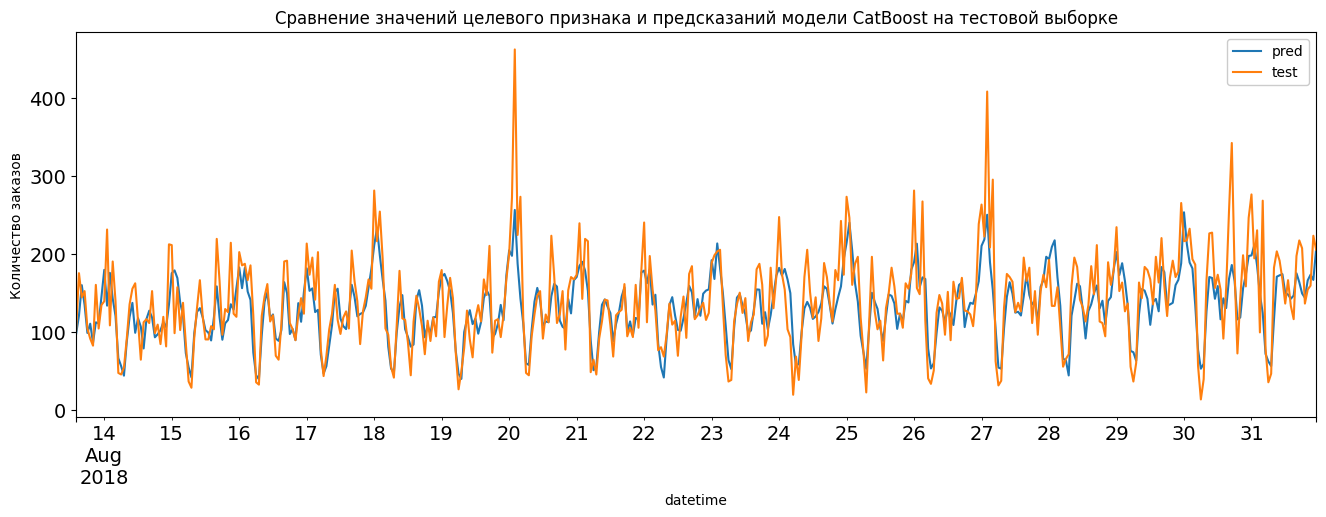

In [37]:
pred_2 = y_test.reset_index()[['datetime', 'num_orders']].copy()

p_2 = pd.Series(model_2.best_estimator_.predict(X_test))
p_2.name = 'p_2'
taxi_comp = pd.merge(pred_2, p_2, left_index=True, right_index=True)

taxi_comp = taxi_comp.set_index(['datetime'])

taxi_comp.columns = ['test', 'pred']

plt.figure(figsize=(16, 5))

taxi_comp['pred'].plot(fontsize=14)
taxi_comp['test'].plot(fontsize=14)
plt.legend(loc = 'best', framealpha=1)
plt.title('Сравнение значений целевого признака и предсказаний модели CatBoost на тестовой выборке')
plt.ylabel('Количество заказов')
plt.show()

In [38]:
print("RMSE тестовой выборки модели CatBoost:", rmse(model_2.best_estimator_.predict(X_test), y_test))

RMSE тестовой выборки модели CatBoost: 36.621900366335645


Итак, в ходе проекта загружены данные о заказах такси. 

В результате анализа показано, что ряд стационарный, имеет сезонность равную 1 суткам. 

Обучены три модели: Prophet, CatBoost и SGDRegressor с подбором гиперпараметров. 

Лучшая модель - CatBoostRegressor. Для улучшения ее работы созданы дополнительные признаки "количество отстающих значений = 168", "размер окна для скользящего среднего = 24" и "размер окна для скользящего среднего = 168".

На тестовой выборке значение метрики RMSE лучшей модели равно 36,62.
